In [1]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time
import random
import os

Importing Jupyter notebook from manta_file_processing.ipynb


In [2]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")

In [3]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [4]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
print("os = "+os.name)
print("folder: "+folder+"\n ---\ncollecting...")
dataset=mfp.get_manta_files(folder=folder)

os = nt
folder: C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some
 ---
collecting...
total:1801
labelled:295


In [5]:
df=dataset[dataset.body_landmark_path.isnull()==False].sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
manta_data.shape

(295, 2)

In [20]:
image_size=[100]*2
heatmap_size=[59]*2

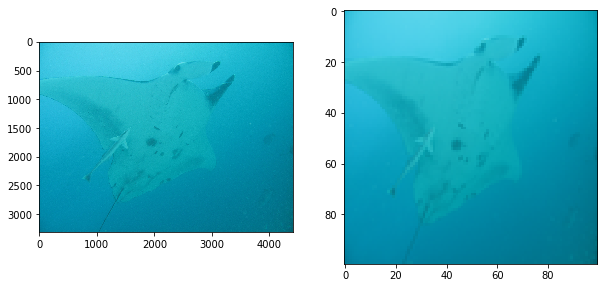

In [7]:
im_path,blm_path = manta_data[56]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)
heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow(image)

image1=mfp.image_to_numpy(image,image_size)
axes[1].imshow(mfp.denormalize(image1))    
#axes[2].imshow(image[:,::-1])   
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


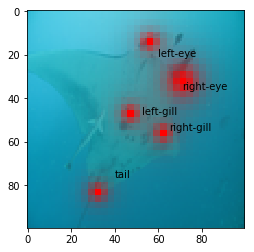

In [8]:
mfp.apply_heatmaps(mfp.denormalize(image1),heatmaps)

In [9]:
def flip_image(image,heatmaps):
    flip_image=image[::-1,:,]
    flip_heatmap=np.moveaxis(heatmaps[::-1,:,],-1,0)
    le,re,lg,rg,t=flip_heatmap
    flip_heatmap=np.array([re,le,rg,lg,t])
    flip_heatmap=np.moveaxis(flip_heatmap,0,-1)
    return flip_image,flip_heatmap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


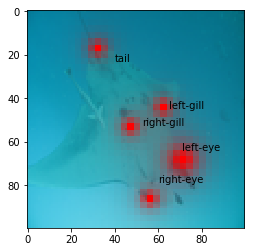

In [10]:
fi,fh=flip_image(mfp.denormalize(image1),heatmaps)
mfp.apply_heatmaps(fi,fh)

In [11]:
X=[]
y=[]
i=0
print ("total:" + str(manta_data.shape[0]))

for im_path,blm_path in manta_data:#[:20]:
    try:
        image = Image.open(im_path)
        body_landmarks=mfp.extract_body_landmarks(blm_path)
    except:
        print(" \n Error on "+blm_path)
        
    image=mfp.image_to_numpy(image,image_size)
    if image.shape[2]>3:
        image=image[:,:,:3]
    numpy_heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)
    #numpy_heatmaps=mfp.heatmaps_to_numpy(heatmaps)
    
    #if image.shape[2]>3:
    #    image=image[:,:,:3]
        #print("\n More then 3 channels")
        #print(blm_path)
        #numpy_heatmaps=None
    
    if numpy_heatmaps is not None and numpy_heatmaps.sum()>0:
        y.append(numpy_heatmaps)
        X.append(image) 
        flip_img, flip_hm=flip_image(image,numpy_heatmaps)
        y.append(flip_hm)
        X.append(flip_img) 
        
    print(i,end=" ")
    i+=1

X=np.array(X)
y=np.array(y)
print("\n====================")
print("Done.\nX.shape="+str(X.shape))
print("y.shape="+str(y.shape))


total:295
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Done.
X.shape=(40, 100, 100, 3)
y.shape=(40, 33, 33, 5)


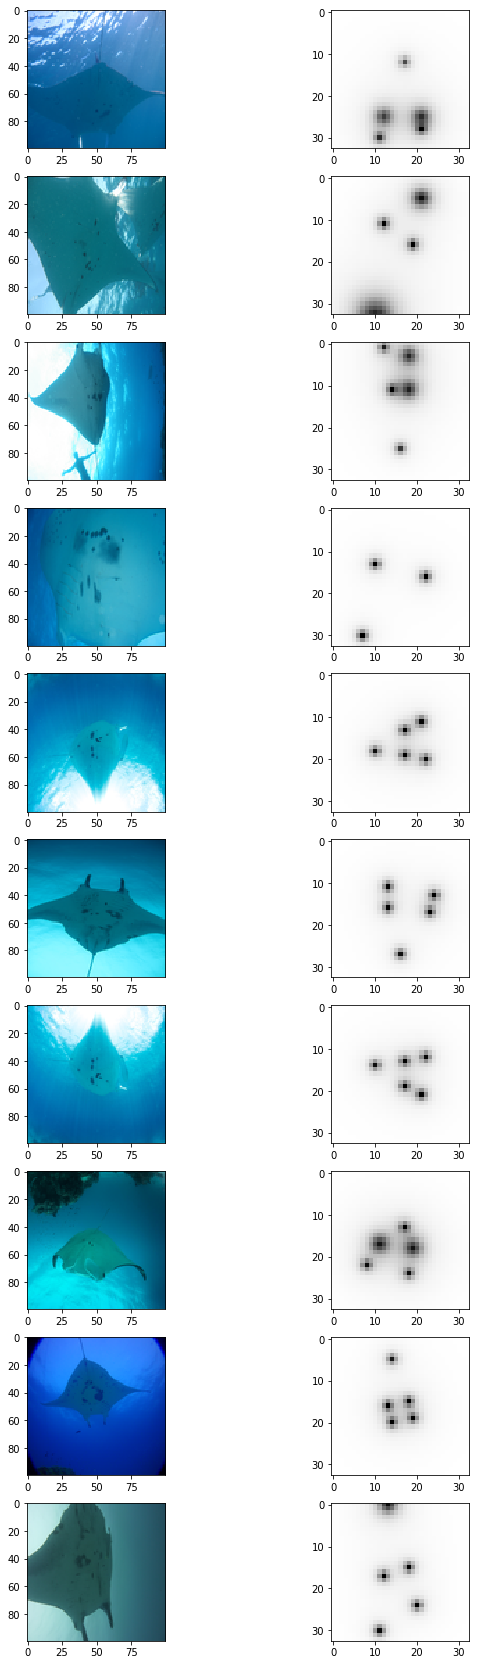

In [12]:
n=10
samples=random.sample(list(np.arange(X.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X[s]))
    axes[i,1].imshow(y[s].sum(axis=2),cmap='Greys')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


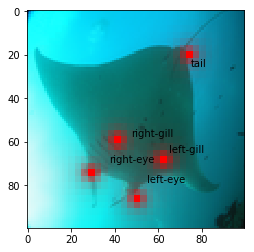

In [38]:
i=100
mfp.apply_heatmaps(mfp.denormalize(X[i]),y[i])
    

In [13]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation
from tensorflow.python.keras.callbacks import EarlyStopping

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [14]:
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
batch_size=8
nb_train_samples=int(round(X.shape[0]*0.95,0))
X_train=X[:nb_train_samples]
X_test =X[nb_train_samples:]
y_train=y[:nb_train_samples]
y_test =y[nb_train_samples:]

In [15]:
#pip install h5py
#pip install cython
#restart jupyther
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False

In [16]:
from tensorflow.keras.models import Model
mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[17].get_output_at(0))
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [19]:
model=Sequential()
#model.add(vgg16_net)
model.add(mymodel)

model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=256,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=128,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=5,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
batch_normalization_12 (Batc (None, 6, 6, 512)         2048      
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 13, 13, 256)       1179904   
_________________________________________________________________
batch_normalization_13 (Batc (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 27, 27, 128)       295040    
_________________________________________________________________
batch_normalization_14 (Batc (None, 27, 27, 128)       512       
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 55, 55, 64)        73792     
__________

In [44]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['binary_accuracy'])

In [45]:
start_time = time.time()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30)

history=model.fit(X_train,y_train,batch_size=32,epochs=1200,validation_split=0.1,callbacks=[early_stopping_callback])

training_time=round(time.time() - start_time,2)

Train on 504 samples, validate on 56 samples
Epoch 1/1200
504/504 [==============================] - 3s 6ms/sample - loss: 23.2795 - binary_accuracy: 0.0462 - val_loss: 34.4561 - val_binary_accuracy: 0.0358
Epoch 2/1200
504/504 [==============================] - 2s 3ms/sample - loss: 21.9882 - binary_accuracy: 0.0468 - val_loss: 22.7234 - val_binary_accuracy: 0.0402
Epoch 3/1200
504/504 [==============================] - 2s 3ms/sample - loss: 21.4559 - binary_accuracy: 0.0469 - val_loss: 19.3826 - val_binary_accuracy: 0.0422
Epoch 4/1200
504/504 [==============================] - 2s 3ms/sample - loss: 21.0946 - binary_accuracy: 0.0511 - val_loss: 18.5252 - val_binary_accuracy: 0.0427
Epoch 5/1200
504/504 [==============================] - 2s 3ms/sample - loss: 20.8124 - binary_accuracy: 0.0525 - val_loss: 18.1840 - val_binary_accuracy: 0.0428
Epoch 6/1200
504/504 [==============================] - 2s 3ms/sample - loss: 20.5660 - binary_accuracy: 0.0534 - val_loss: 18.0156 - val_binary_

504/504 [==============================] - 2s 3ms/sample - loss: 12.5547 - binary_accuracy: 0.0546 - val_loss: 11.2109 - val_binary_accuracy: 0.0429
Epoch 52/1200
504/504 [==============================] - 2s 3ms/sample - loss: 12.4312 - binary_accuracy: 0.0546 - val_loss: 11.1028 - val_binary_accuracy: 0.0429
Epoch 53/1200
504/504 [==============================] - 2s 3ms/sample - loss: 12.3110 - binary_accuracy: 0.0546 - val_loss: 11.0045 - val_binary_accuracy: 0.0429
Epoch 54/1200
504/504 [==============================] - 2s 3ms/sample - loss: 12.1915 - binary_accuracy: 0.0546 - val_loss: 10.8977 - val_binary_accuracy: 0.0429
Epoch 55/1200
504/504 [==============================] - 2s 3ms/sample - loss: 12.0775 - binary_accuracy: 0.0546 - val_loss: 10.7779 - val_binary_accuracy: 0.0429
Epoch 56/1200
504/504 [==============================] - 2s 3ms/sample - loss: 11.9606 - binary_accuracy: 0.0546 - val_loss: 10.6840 - val_binary_accuracy: 0.0429
Epoch 57/1200
504/504 [=============

Epoch 102/1200
504/504 [==============================] - 2s 3ms/sample - loss: 8.0822 - binary_accuracy: 0.0546 - val_loss: 7.2510 - val_binary_accuracy: 0.0429
Epoch 103/1200
504/504 [==============================] - 2s 3ms/sample - loss: 8.0219 - binary_accuracy: 0.0546 - val_loss: 7.1819 - val_binary_accuracy: 0.0429
Epoch 104/1200
504/504 [==============================] - 2s 3ms/sample - loss: 7.9653 - binary_accuracy: 0.0546 - val_loss: 7.1448 - val_binary_accuracy: 0.0429
Epoch 105/1200
504/504 [==============================] - 2s 3ms/sample - loss: 7.9086 - binary_accuracy: 0.0546 - val_loss: 7.0962 - val_binary_accuracy: 0.0429
Epoch 106/1200
504/504 [==============================] - 2s 3ms/sample - loss: 7.8511 - binary_accuracy: 0.0546 - val_loss: 7.0446 - val_binary_accuracy: 0.0429
Epoch 107/1200
504/504 [==============================] - 2s 3ms/sample - loss: 7.7901 - binary_accuracy: 0.0546 - val_loss: 6.9842 - val_binary_accuracy: 0.0429
Epoch 108/1200
504/504 [====

Epoch 203/1200
504/504 [==============================] - 2s 3ms/sample - loss: 4.6541 - binary_accuracy: 0.0546 - val_loss: 4.2172 - val_binary_accuracy: 0.0429
Epoch 204/1200
504/504 [==============================] - 2s 3ms/sample - loss: 4.6363 - binary_accuracy: 0.0546 - val_loss: 4.2148 - val_binary_accuracy: 0.0428
Epoch 205/1200
504/504 [==============================] - 2s 3ms/sample - loss: 4.6198 - binary_accuracy: 0.0546 - val_loss: 4.1768 - val_binary_accuracy: 0.0429
Epoch 206/1200
504/504 [==============================] - 2s 3ms/sample - loss: 4.6023 - binary_accuracy: 0.0546 - val_loss: 4.1834 - val_binary_accuracy: 0.0429
Epoch 207/1200
504/504 [==============================] - 2s 3ms/sample - loss: 4.5862 - binary_accuracy: 0.0546 - val_loss: 4.1678 - val_binary_accuracy: 0.0429
Epoch 208/1200
504/504 [==============================] - 2s 3ms/sample - loss: 4.5693 - binary_accuracy: 0.0546 - val_loss: 4.1617 - val_binary_accuracy: 0.0429
Epoch 209/1200
504/504 [====

Epoch 304/1200
504/504 [==============================] - 2s 3ms/sample - loss: 3.5318 - binary_accuracy: 0.0546 - val_loss: 3.3643 - val_binary_accuracy: 0.0429
Epoch 305/1200
504/504 [==============================] - 2s 3ms/sample - loss: 3.5199 - binary_accuracy: 0.0546 - val_loss: 3.3445 - val_binary_accuracy: 0.0429
Epoch 306/1200
504/504 [==============================] - 2s 3ms/sample - loss: 3.5161 - binary_accuracy: 0.0546 - val_loss: 3.3211 - val_binary_accuracy: 0.0429
Epoch 307/1200
504/504 [==============================] - 2s 3ms/sample - loss: 3.5118 - binary_accuracy: 0.0546 - val_loss: 3.3278 - val_binary_accuracy: 0.0429
Epoch 308/1200
504/504 [==============================] - 2s 3ms/sample - loss: 3.5026 - binary_accuracy: 0.0546 - val_loss: 3.3335 - val_binary_accuracy: 0.0429
Epoch 309/1200
504/504 [==============================] - 2s 3ms/sample - loss: 3.4979 - binary_accuracy: 0.0546 - val_loss: 3.3306 - val_binary_accuracy: 0.0429
Epoch 310/1200
504/504 [====

Epoch 405/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.7975 - binary_accuracy: 0.0547 - val_loss: 3.0064 - val_binary_accuracy: 0.0429
Epoch 406/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.7933 - binary_accuracy: 0.0547 - val_loss: 3.0058 - val_binary_accuracy: 0.0429
Epoch 407/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.7900 - binary_accuracy: 0.0547 - val_loss: 2.9965 - val_binary_accuracy: 0.0429
Epoch 408/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.7879 - binary_accuracy: 0.0547 - val_loss: 2.9895 - val_binary_accuracy: 0.0429
Epoch 409/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.7871 - binary_accuracy: 0.0547 - val_loss: 2.9965 - val_binary_accuracy: 0.0429
Epoch 410/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.7797 - binary_accuracy: 0.0547 - val_loss: 3.0082 - val_binary_accuracy: 0.0429
Epoch 411/1200
504/504 [====

Epoch 506/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.5703 - binary_accuracy: 0.0548 - val_loss: 2.9462 - val_binary_accuracy: 0.0429
Epoch 507/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.5668 - binary_accuracy: 0.0548 - val_loss: 2.9217 - val_binary_accuracy: 0.0429
Epoch 508/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.5615 - binary_accuracy: 0.0548 - val_loss: 2.9500 - val_binary_accuracy: 0.0429
Epoch 509/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.5629 - binary_accuracy: 0.0548 - val_loss: 2.9348 - val_binary_accuracy: 0.0429
Epoch 510/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.5626 - binary_accuracy: 0.0548 - val_loss: 2.9142 - val_binary_accuracy: 0.0429
Epoch 511/1200
504/504 [==============================] - 2s 3ms/sample - loss: 2.5647 - binary_accuracy: 0.0548 - val_loss: 2.9210 - val_binary_accuracy: 0.0429
Epoch 512/1200
504/504 [====


Training time :'--- 14.0 min 33.40999999999997 sec ---


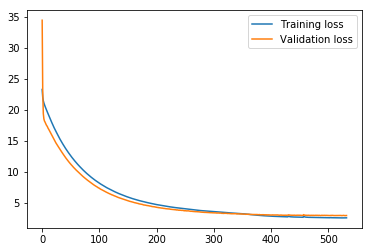

In [46]:
print("\nTraining time :'--- %s min %s sec ---" % (training_time//60,training_time%60) )
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [22]:
pred=model.predict(X_test)
print(X_test.shape)
print(pred.shape)

(30, 100, 100, 3)
(30, 17, 17, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


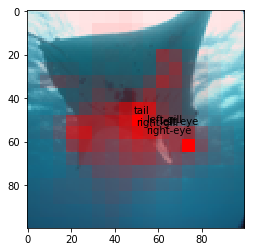

In [47]:
i=14
mfp.apply_heatmaps(mfp.denormalize(X_test[i]),pred[i])

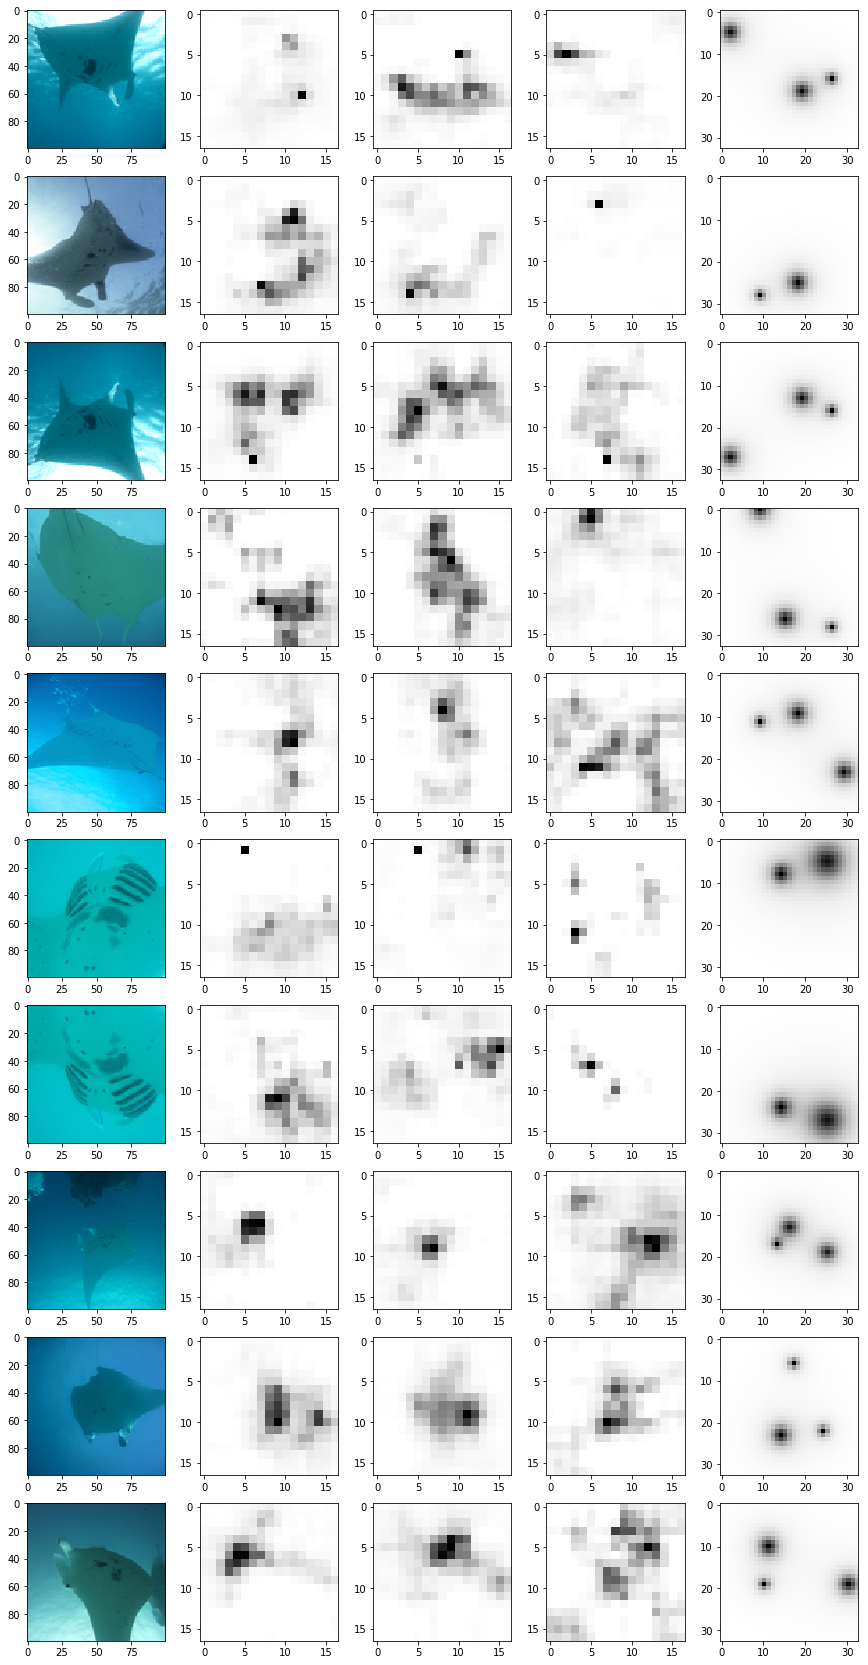

In [48]:
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=5,figsize=(15, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X_test[s]))
    axes[i,1].imshow(pred[s][:,:,0],cmap='Greys')
    axes[i,2].imshow(pred[s][:,:,1],cmap='Greys')
    #axes[i,3].imshow(pred[s][:,:,2],cmap='Greys')
    axes[i,3].imshow(pred[s][:,:,4],cmap='Greys')
    axes[i,4].imshow(y_test[s][:,:,[0,1,4]].sum(axis=2),cmap='Greys')
plt.show()